In [17]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


In [18]:
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
import glob
from skimage.io import imread
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np 
import os
from keras import backend as K
from sklearn.cluster import MiniBatchKMeans,KMeans
from collections import Counter
from sklearn.decomposition import PCA
#import lda
import time
#%%
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from function import newtxt,newimagedata,create_plots,plot_confusion_matrix,cnn_model,cnn_model1,cnn_model2

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np 
import os
from keras.utils.vis_utils import plot_model
from sklearn.decomposition import PCA

In [19]:
count = 0
all_divide_image = np.zeros([1,32,32,3])
read_files = glob.glob("./2012raw_data/*.txt")
for name in read_files:
    name = name.split("/")[2]
    name = name.split(".")[0]
    path_image = str('./2012image/')+name+str('.jpg')
    single_img = imread(path_image)
    divide_image = np.zeros([3072,32,32,3])
    count_patch = 0
    for i in range(64):
        for j in range(48):
            divide_image[count_patch,:,:,:] = single_img[j*32:(j+1)*32,i*32:(i+1)*32]
            count_patch = count_patch + 1
    all_divide_image = np.vstack((all_divide_image,divide_image))
    count = count + 1
    print("---image %d finished" % (count))

---image 1 finished
---image 2 finished
---image 3 finished
---image 4 finished
---image 5 finished
---image 6 finished
---image 7 finished
---image 8 finished
---image 9 finished
---image 10 finished
---image 11 finished
---image 12 finished
---image 13 finished
---image 14 finished
---image 15 finished
---image 16 finished
---image 17 finished
---image 18 finished
---image 19 finished
---image 20 finished
---image 21 finished
---image 22 finished
---image 23 finished
---image 24 finished
---image 25 finished
---image 26 finished
---image 27 finished
---image 28 finished
---image 29 finished
---image 30 finished
---image 31 finished
---image 32 finished
---image 33 finished
---image 34 finished
---image 35 finished
---image 36 finished
---image 37 finished
---image 38 finished
---image 39 finished
---image 40 finished
---image 41 finished
---image 42 finished
---image 43 finished
---image 44 finished
---image 45 finished
---image 46 finished
---image 47 finished
---image 48 finished
-

In [20]:
all_divide_image = all_divide_image[1:]

In [27]:
num = all_divide_image.shape[0]
all_divide_image = all_divide_image.reshape(num,3072)

In [29]:
import random
random.shuffle(all_divide_image)

In [30]:
all_divide_image = all_divide_image.reshape(num,32,32,3)

In [31]:
batch_size = 32
num_classes = 10
epochs = 100
x_train = all_divide_image[0:300000]
x_test = all_divide_image[300000:]

In [32]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (300000, 32, 32, 3)
300000 train samples
68640 test samples


In [33]:
from keras.layers import Input,BatchNormalization,UpSampling2D
from keras.models import load_model,Model

In [34]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [35]:
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='binary_crossentropy')

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 32)        128       
__________

In [38]:
x_val = x_test[:20000]
x_test = x_test[20000:]
print("validation data: {0} \ntest data: {1}".format(x_val.shape, x_test.shape))

validation data: (20000, 32, 32, 3) 
test data: (38640, 32, 32, 3)


In [39]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = 'AutoEncoder_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [40]:
history = model.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, x_val),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

Train on 300000 samples, validate on 20000 samples
Epoch 1/100
300000/300000 [==============================] - 313s 1ms/step - loss: 0.5364 - val_loss: 0.5266

Epoch 00001: val_loss improved from inf to 0.52655, saving model to AutoEncoder_weights.01-0.54-0.53.hdf5
Epoch 2/100
300000/300000 [==============================] - 312s 1ms/step - loss: 0.5321 - val_loss: 0.5251

Epoch 00002: val_loss improved from 0.52655 to 0.52513, saving model to AutoEncoder_weights.02-0.53-0.53.hdf5
Epoch 3/100
300000/300000 [==============================] - 312s 1ms/step - loss: 0.5311 - val_loss: 0.5241

Epoch 00003: val_loss improved from 0.52513 to 0.52407, saving model to AutoEncoder_weights.03-0.53-0.52.hdf5
Epoch 4/100
300000/300000 [==============================] - 313s 1ms/step - loss: 0.5306 - val_loss: 0.5245

Epoch 00004: val_loss did not improve
Epoch 5/100
300000/300000 [==============================] - 312s 1ms/step - loss: 0.5303 - val_loss: 0.5239

Epoch 00005: val_loss improved from

In [41]:
# definition to show original image and reconstructed image
def showOrigDec(orig, dec, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [42]:
c10test = model.predict(x_test)
c10val = model.predict(x_val)

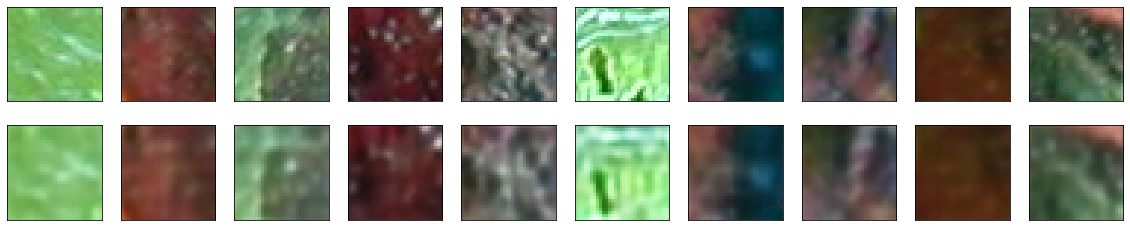

In [43]:
showOrigDec(x_test, c10test)

In [45]:
import lda

ImportError: No module named 'lda'